In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
import plotly.express as px

from pyspark.mllib.clustering import BisectingKMeans as BM
from pyspark.mllib.clustering import BisectingKMeansModel
from pyspark.ml.clustering import BisectingKMeans
spark = SparkSession.Builder().appName('DDAM_Project_South').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/04 14:14:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/South_Incidents_Cleaned.csv')

In [8]:
df_cluster=df
df_cluster.count()

173598

In [5]:
#to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Astronomical_Twilight', 'day_of_the_week','month','hour','season']
#df_cluster=df_cluster.drop(*to_drop) # con asterisco passo gli elementi singoli al metodo drop
#df_cluster.show()

Normalization

In [11]:
col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in', 'month','hour']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

clusteringData = output_dataset.select("features_scaled", "Severity")

#clusteringData.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|features_scaled                                                                                                                                                         |Severity|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[0.6659159634503666,0.16218209593132324,0.00812609543477642,0.5040650406504066,0.11111111111111112,0.5,0.08264462809917356,0.0,0.2727272727272727,0.13043478260869565]  |2       |
|[0.604466859525906,0.187643693810282,0.004652821005798856,0.6585365853658537,0.26262626262626265,0.5,0.0743801652892562,0.0,0.2727272727272727,0.9565217391304348]      |2       |
|[0.6236400791462584,0.1882086426001484,2.4660545560747455E-4,0.6422764227642277,0.10101010101010102

K-Means with k in range[2-30]

In [7]:
#!pip install kneed
#!pip install yellowbrick
from kneed import KneeLocator
import matplotlib.pyplot as plt


sse_values = []
silhouette_values = []
for k in range(2,30):

    print('************************************************\n')
    kmeans = KMeans(featuresCol="features_scaled", k=k)
    model = kmeans.fit(clusteringData)
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    predictions = model.transform(clusteringData)
    silhouette = evaluator.evaluate(predictions)
    sse = model.summary.trainingCost
    
    print(f"Results for K = {k}")
    print(f"Silhouette with squared euclidean distance: {silhouette:.4f}")
    print(f"SSE (Sum of Squared Errors): {sse}")
    sse_values.append(sse)
    silhouette_values.append(silhouette)

# Plot SSE per valutare l'elbow
plt.figure()
plt.plot(range(2, 30), sse_values, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 30), sse_values, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

plt.figure()
plt.plot(range(2, 30), silhouette_values, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.title("Silhouette Method for Optimal K")
plt.show()


************************************************



Results for K = 2
Silhouette with squared euclidean distance: 0.6363
SSE (Sum of Squared Errors): 8103.157716089286
************************************************



Results for K = 3
Silhouette with squared euclidean distance: 0.4875
SSE (Sum of Squared Errors): 6195.5136968972065
************************************************



Results for K = 4
Silhouette with squared euclidean distance: 0.5141
SSE (Sum of Squared Errors): 5000.644855677529
************************************************



Results for K = 5
Silhouette with squared euclidean distance: 0.5321
SSE (Sum of Squared Errors): 4097.810448585989
************************************************



ERROR:root:KeyboardInterrupt while sending command.                 (0 + 9) / 9]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

Facendo un tradeoff tra silhouette e SSE si puo dire che il k ideale per i nostri dati è compreso tra [3-8]

K-Means(K=6) with respect to Severity

Silhouette  = 0.3489026276183117

SSE  = 25982.076599284905


Contingency Table:
severity       1      2     3    4
prediction                        
0             88  34639  1067  625
1           2277  24558  1078  771
2            710  34486  1493  694
3           1754  20538  2699  246
4             76  13904  1487  187
5            281  25732  3928  280


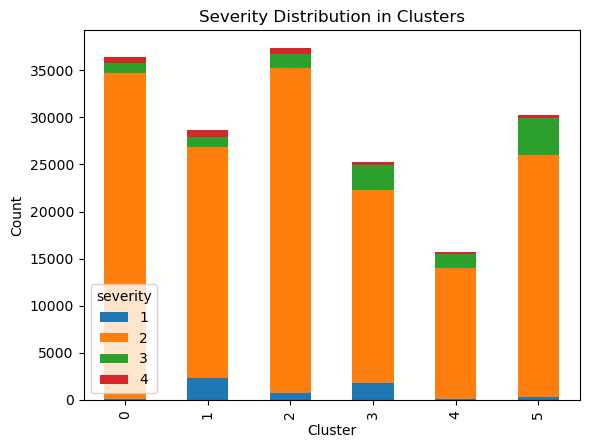

In [12]:
clusteringData_severity = output_dataset.select("features_scaled", "Severity")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_severity)
predictions = model.transform(clusteringData_severity)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'severity').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='severity', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=6) with respect to State

Silhouette  = 0.3489026276183117

SSE  = 25982.07659928491


Contingency Table:
state            AZ      LA     MS     NM       TX
prediction                                        
0             849.0  8637.0  797.0   63.0  26073.0
1            2734.0  5140.0  540.0  182.0  20088.0
2           35217.0     NaN    NaN  838.0   1328.0
3             547.0  5991.0  721.0  265.0  17713.0
4              76.0  6873.0  642.0   61.0   8002.0
5               NaN  7129.0  783.0    4.0  22305.0


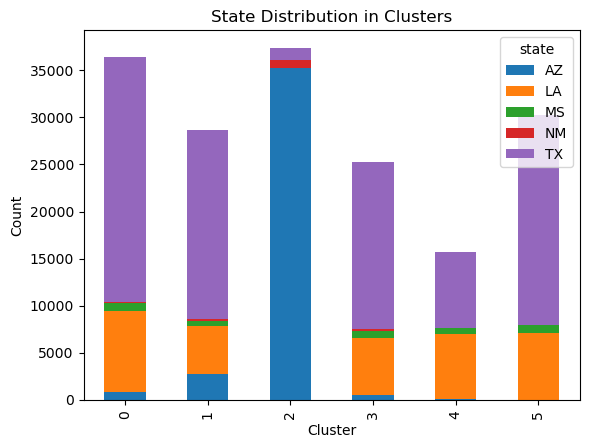

In [13]:
clusteringData_state = output_dataset.select("features_scaled", "State")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_state)
predictions = model.transform(clusteringData_state)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'state').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='state', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='State Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=6) with respect to Astronomical Twilight

Silhouette  = 0.3489026276183117

SSE  = 25982.076599284905


Contingency Table:
Astronomical_Twilight    Day  Night
prediction                         
0                      29446   6973
1                      21289   7395
2                      31720   5663
3                      20714   4523
4                      12484   3170
5                      29365    856


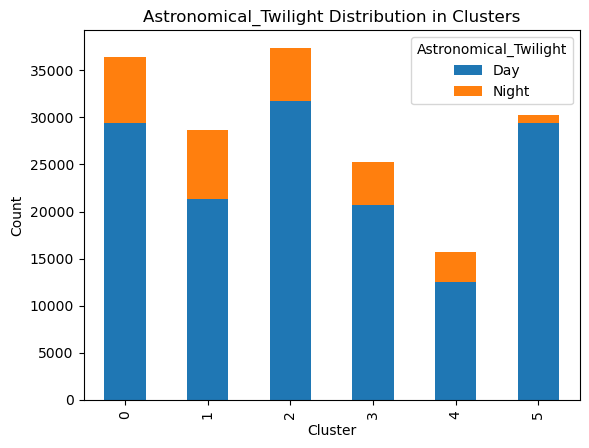

In [14]:
clusteringData_day = output_dataset.select("features_scaled", "Astronomical_Twilight")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_day)
predictions = model.transform(clusteringData_day)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=6) with respect to Weather_Condition

Silhouette  = 0.3489026276183117

SSE  = 25982.07659928491


Contingency Table:
Weather_Condition  Cloudy  Foggy  Normal  Rain  Snow
prediction                                          
0                   15177    232   18973  1994    43
1                   11474    882   13027  3191   110
2                    7428    174   29099   650    32
3                   12388    725    9851  1698   575
4                    8387    200    4385  2531   151
5                    9461    144   20469   146     1


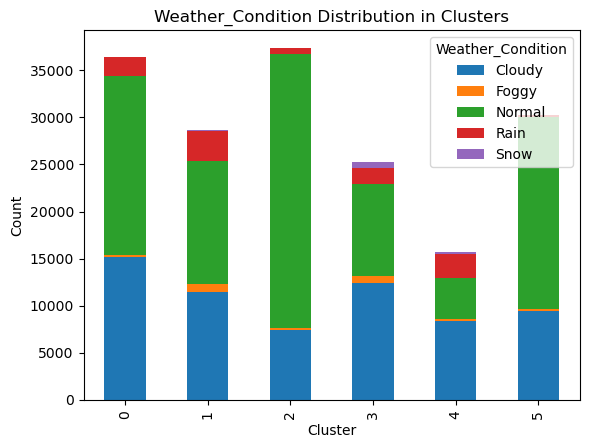

In [15]:
clusteringData_condition = output_dataset.select("features_scaled", "Weather_Condition")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Silhouette  = 0.3489026276183117

SSE  = 25982.07659928491


Contingency Table:
day_of_the_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
prediction                                                             
0                  6763    4571      4925    3180      6176     5026   
1                  4432    4756      2840    2488      5055     4582   
2                  6619    5225      3896    3047      6013     6083   
3                  3552    4268      1698    1385      4614     4507   
4                  2729    2090      1920    1355      2033     2756   
5                  5844    4053      3498    2192      5565     4277   

day_of_the_week  Wednesday  
prediction                  
0                     5778  
1                     4531  
2                     6500  
3                     5213  
4                     2771  
5                     4792  


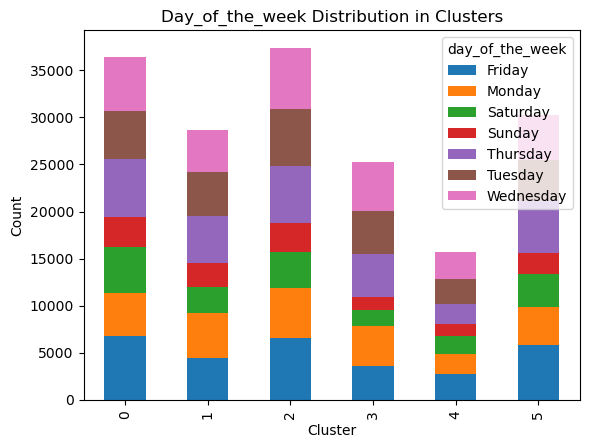

In [16]:
clusteringData_condition = output_dataset.select("features_scaled", "day_of_the_week")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'day_of_the_week').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='day_of_the_week', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Day_of_the_week Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Silhouette  = 0.3489026276183117

SSE  = 25982.076599284905


Contingency Table:
season       Autumn   Spring  Summer  Winter
prediction                                  
0           19110.0      NaN  7436.0  9873.0
1           11924.0      NaN  9926.0  6834.0
2            6897.0  13382.0  8568.0  8536.0
3               NaN  13006.0  3124.0  9107.0
4               NaN   7337.0  2018.0  6299.0
5               2.0  14669.0  8530.0  7020.0


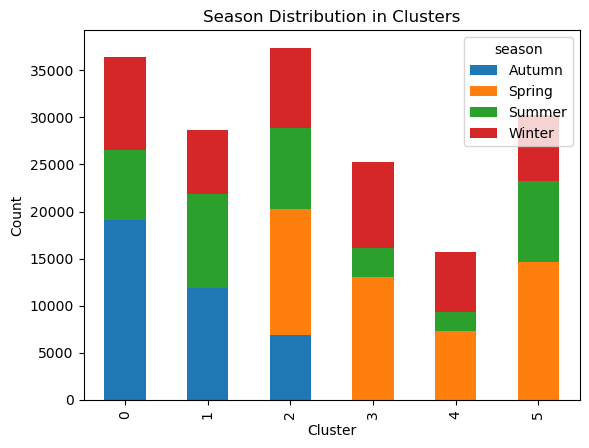

In [17]:
clusteringData_condition = output_dataset.select("features_scaled", "season")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'season').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='season', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Season Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [4]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
def workingDay_weekend(day_of):
    ins={'Monday','Tuesday','Wednesday','Thursday','Friday'}
    if day_of in ins:
        return 'WorkingDay'
    else:
        return 'Weekend'

udf_workingDay_weekend = udf(workingDay_weekend, StringType())
df = df.withColumn("Working_Weekend", udf_workingDay_weekend(col("day_of_the_week")))

In [24]:
col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in', 'month','hour']

df_cluster=df

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

clusteringData = output_dataset.select("features_scaled")

Silhouette  = 0.3489026276183117

SSE  = 25982.076599284905


Contingency Table:
Working_Weekend  Weekend  WorkingDay
prediction                          
0                   8105       28314
1                   5328       23356
2                   6943       30440
3                   3083       22154
4                   3275       12379
5                   5690       24531


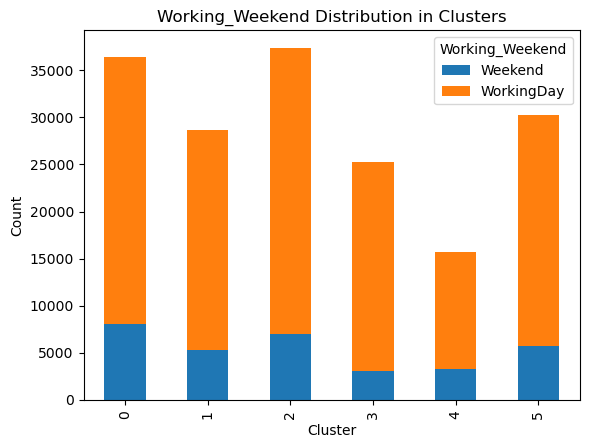

In [25]:
clusteringData_condition = output_dataset.select("features_scaled", "Working_Weekend")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Working_Weekend').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Working_Weekend', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Working_Weekend Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=8) with respect to Severity

Silhouette  = 0.3692677213945747

SSE  = 21333.25280850713


Contingency Table:
severity       1      2     3    4
prediction                        
0            217  16423  2045  189
1              2  16461    30  419
2            408  21518  1167  344
3             94  14559  1499  175
4             89  28563  1363  511
5            137  22266  3315  226
6            390  16855   364  499
7           3849  17212  1969  440


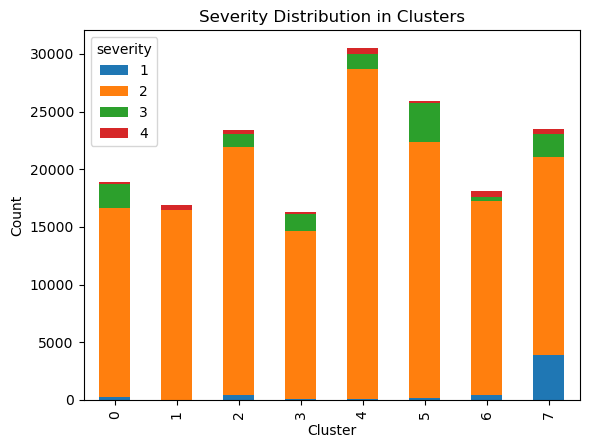

In [26]:
clusteringData_severity = output_dataset.select("features_scaled", "Severity")

kmeans = KMeans(featuresCol="features_scaled").setK(8)
model = kmeans.fit(clusteringData_severity)
predictions = model.transform(clusteringData_severity)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'severity').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='severity', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=8) with respect to State

Silhouette  = 0.3692677213945747

SSE  = 21333.252808507128


Contingency Table:
state            AZ      LA     MS     NM       TX
prediction                                        
0             560.0  4203.0  566.0  282.0  13263.0
1              82.0  3568.0  318.0   49.0  12895.0
2           22038.0     NaN    NaN  530.0    869.0
3              43.0  7404.0  677.0   24.0   8179.0
4               NaN  5817.0  634.0    3.0  24072.0
5               NaN  6480.0  686.0    NaN  18778.0
6           16686.0     NaN    NaN  497.0    925.0
7              14.0  6298.0  602.0   28.0  16528.0


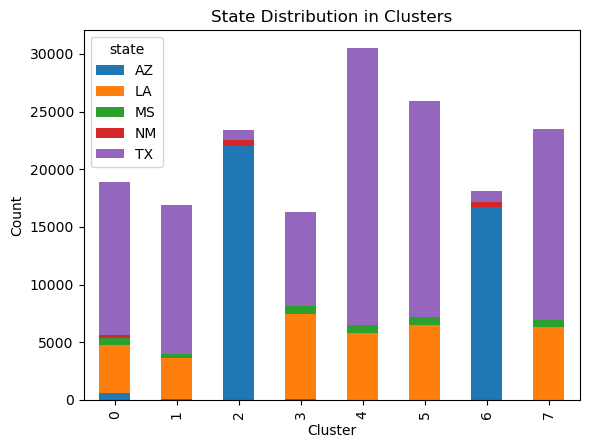

In [27]:
clusteringData_state = output_dataset.select("features_scaled", "State")

kmeans = KMeans(featuresCol="features_scaled").setK(8)
model = kmeans.fit(clusteringData_state)
predictions = model.transform(clusteringData_state)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'state').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='state', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='State Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=8) with respect to Astronomical Twilight

Silhouette  = 0.3692677213945747

SSE  = 21333.252808507128


Contingency Table:
Astronomical_Twilight    Day  Night
prediction                         
0                      15452   3422
1                      12370   4542
2                      20150   3287
3                      13026   3301
4                      25969   4557
5                      25070    874
6                      14116   3992
7                      18865   4605


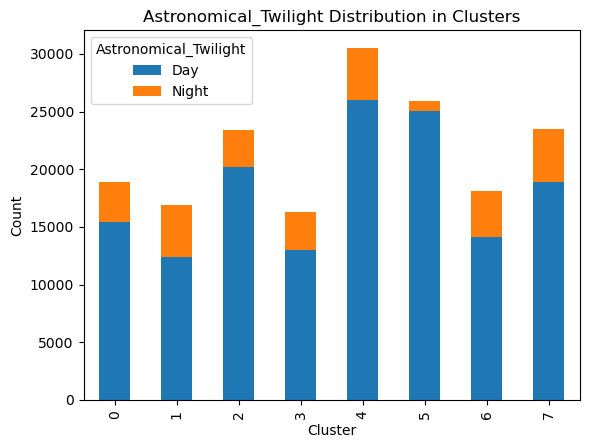

In [28]:
clusteringData_day = output_dataset.select("features_scaled", "Astronomical_Twilight")

kmeans = KMeans(featuresCol="features_scaled").setK(8)
model = kmeans.fit(clusteringData_day)
predictions = model.transform(clusteringData_day)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=8) with respect to Weather_Condition

Silhouette  = 0.3692677213945747

SSE  = 21333.252808507128


Contingency Table:
Weather_Condition   Cloudy  Foggy   Normal    Rain   Snow
prediction                                               
0                   9110.0  640.0   6898.0  1575.0  651.0
1                   9071.0  954.0   4344.0  2498.0   45.0
2                   3518.0   74.0  19708.0   127.0   10.0
3                   8818.0  210.0   4647.0  2559.0   93.0
4                  11440.0   30.0  18427.0   628.0    1.0
5                   7368.0  100.0  18390.0    85.0    1.0
6                   5314.0  157.0  11594.0   932.0  111.0
7                   9676.0  192.0  11796.0  1806.0    NaN


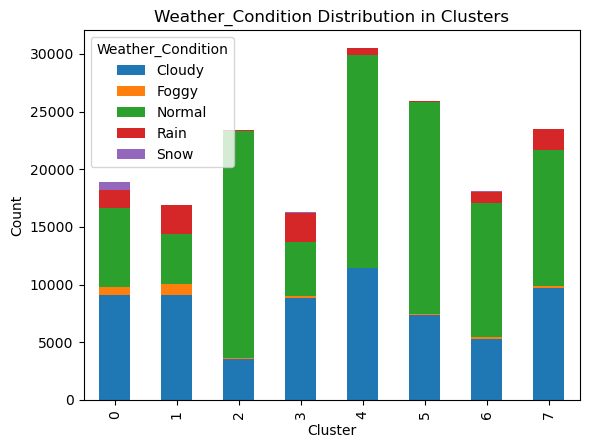

In [29]:
clusteringData_condition = output_dataset.select("features_scaled", "Weather_Condition")

kmeans = KMeans(featuresCol="features_scaled").setK(8)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Silhouette  = 0.3692677213945747

SSE  = 21333.252808507128


Contingency Table:
day_of_the_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
prediction                                                             
0                  2684    3155      1405    1035      3281     3292   
1                  2758    2992      1898    1445      2880     2571   
2                  4307    3252      2420    1828      3746     3785   
3                  2873    2267      1933    1448      2174     2822   
4                  5703    3567      4188    2712      5247     4156   
5                  5030    3468      2971    1836      4784     3738   
6                  2933    2551      2023    1634      2954     2882   
7                  3651    3711      1939    1709      4390     3985   

day_of_the_week  Wednesday  
prediction                  
0                     4022  
1                     2368  
2                     4099  
3                     2810  
4                     4953  
5                     4117  
6                     3131  

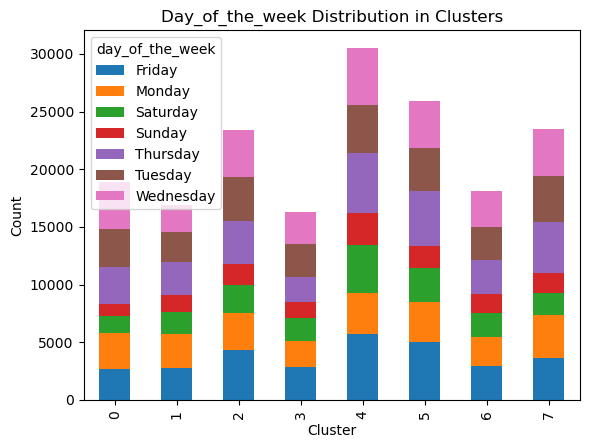

In [30]:
clusteringData_condition = output_dataset.select("features_scaled", "day_of_the_week")

kmeans = KMeans(featuresCol="features_scaled").setK(8)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'day_of_the_week').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='day_of_the_week', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Day_of_the_week Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Silhouette  = 0.3692677213945747

SSE  = 21333.252808507128


Contingency Table:
season       Autumn   Spring   Summer  Winter
prediction                                   
0               NaN   9241.0      NaN  9633.0
1            7637.0      NaN     65.0  9210.0
2               NaN  13366.0   3440.0  6631.0
3              30.0   8260.0   3063.0  4974.0
4           16875.0      NaN   8367.0  5284.0
5               NaN  14000.0   4202.0  7742.0
6            8255.0      4.0   5654.0  4195.0
7            5136.0   3523.0  14811.0     NaN


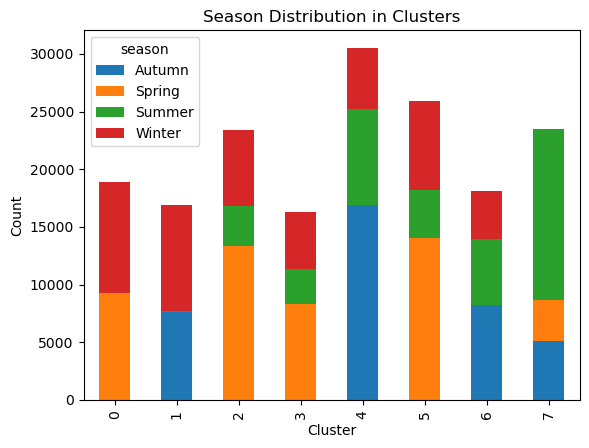

In [31]:
clusteringData_condition = output_dataset.select("features_scaled", "season")

kmeans = KMeans(featuresCol="features_scaled").setK(8)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'season').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='season', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Season Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [33]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
def workingDay_weekend(day_of):
    ins={'Monday','Tuesday','Wednesday','Thursday','Friday'}
    if day_of in ins:
        return 'WorkingDay'
    else:
        return 'Weekend'

udf_workingDay_weekend = udf(workingDay_weekend, StringType())
df = df.withColumn("Working_Weekend", udf_workingDay_weekend(col("day_of_the_week")))

Silhouette  = 0.3692677213945747

SSE  = 21333.252808507128


Contingency Table:
Working_Weekend  Weekend  WorkingDay
prediction                          
0                   2440       16434
1                   3343       13569
2                   4248       19189
3                   3381       12946
4                   6900       23626
5                   4807       21137
6                   3657       14451
7                   3648       19822


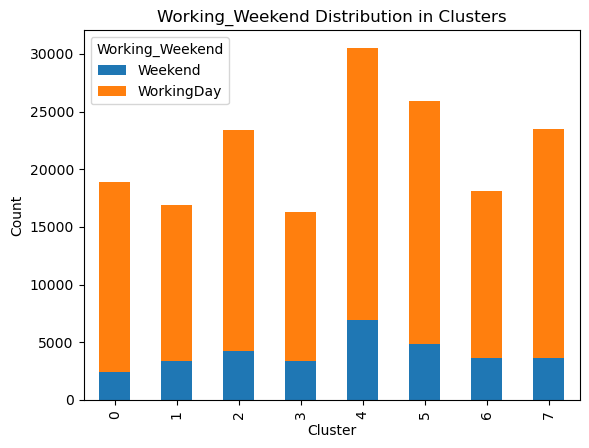

In [32]:
clusteringData_condition = output_dataset.select("features_scaled", "Working_Weekend")

kmeans = KMeans(featuresCol="features_scaled").setK(8)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Working_Weekend').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Working_Weekend', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Working_Weekend Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Bisecting K-Means with k in range(2,30)

+-------------------------------------------------------------------------------------------+--------+
|features_scaled                                                                            |Severity|
+-------------------------------------------------------------------------------------------+--------+
|[0.00812609543477642,0.5040650406504066,0.11111111111111112,0.5,0.08264462809917356,0.0]   |2       |
|[0.004652821005798856,0.6585365853658537,0.26262626262626265,0.5,0.0743801652892562,0.0]   |2       |
|[2.4660545560747455E-4,0.6422764227642277,0.10101010101010102,0.5,0.08264462809917356,0.0] |2       |
|[0.0029562943172221343,0.5934959349593496,0.14141414141414144,0.5,0.1652892561983471,0.0]  |2       |
|[0.0029562943172221343,0.5934959349593496,0.14141414141414144,0.5,0.1652892561983471,0.0]  |2       |
|[0.006010636586673747,0.6422764227642277,0.09090909090909091,0.5,0.14049586776859505,0.0]  |2       |
|[0.006010636586673747,0.6422764227642277,0.09090909090909091,0.5,0.14049

Results for K = 2
Silhouette with squared euclidean distance: 0.6363
SSE (Sum of Squared Errors): 8103.156274020133
************************************************



Results for K = 3
Silhouette with squared euclidean distance: 0.4661
SSE (Sum of Squared Errors): 6869.545418071364
************************************************



Results for K = 4
Silhouette with squared euclidean distance: 0.3933
SSE (Sum of Squared Errors): 5530.9320782561335
************************************************



Results for K = 5
Silhouette with squared euclidean distance: 0.3630
SSE (Sum of Squared Errors): 4830.031110349168
************************************************



Results for K = 6
Silhouette with squared euclidean distance: 0.3937
SSE (Sum of Squared Errors): 4008.758234071118
************************************************



Results for K = 7
Silhouette with squared euclidean distance: 0.3878
SSE (Sum of Squared Errors): 3579.5133007943787
************************************************



Results for K = 8
Silhouette with squared euclidean distance: 0.4313
SSE (Sum of Squared Errors): 2887.6157139939496
************************************************



Results for K = 9
Silhouette with squared euclidean distance: 0.3668
SSE (Sum of Squared Errors): 2706.4802734892255
************************************************



Results for K = 10
Silhouette with squared euclidean distance: 0.4096
SSE (Sum of Squared Errors): 2359.5662993284586
************************************************



Results for K = 11
Silhouette with squared euclidean distance: 0.3975
SSE (Sum of Squared Errors): 2259.1149823956002
************************************************



Results for K = 12
Silhouette with squared euclidean distance: 0.3834
SSE (Sum of Squared Errors): 2110.0603152817876
************************************************



Results for K = 13
Silhouette with squared euclidean distance: 0.3884
SSE (Sum of Squared Errors): 1972.8148283783185
************************************************



Results for K = 14
Silhouette with squared euclidean distance: 0.3780
SSE (Sum of Squared Errors): 1907.7067668642867
************************************************



Results for K = 15
Silhouette with squared euclidean distance: 0.3751
SSE (Sum of Squared Errors): 1841.943201932765
************************************************



Results for K = 16
Silhouette with squared euclidean distance: 0.3785
SSE (Sum of Squared Errors): 1722.4463111665887
************************************************



Results for K = 17
Silhouette with squared euclidean distance: 0.3607
SSE (Sum of Squared Errors): 1689.7353679275461
************************************************



Results for K = 18
Silhouette with squared euclidean distance: 0.3429
SSE (Sum of Squared Errors): 1648.2214042626224
************************************************



Results for K = 19
Silhouette with squared euclidean distance: 0.3374
SSE (Sum of Squared Errors): 1615.8740725953216
************************************************



Results for K = 20
Silhouette with squared euclidean distance: 0.3204
SSE (Sum of Squared Errors): 1581.3272322134585
************************************************



Results for K = 21
Silhouette with squared euclidean distance: 0.3155
SSE (Sum of Squared Errors): 1535.816775741037
************************************************



Results for K = 22
Silhouette with squared euclidean distance: 0.3129
SSE (Sum of Squared Errors): 1494.9572564345422
************************************************



Results for K = 23
Silhouette with squared euclidean distance: 0.3078
SSE (Sum of Squared Errors): 1477.1358540039873
************************************************



Results for K = 24
Silhouette with squared euclidean distance: 0.3101
SSE (Sum of Squared Errors): 1440.9548216420114
************************************************



Results for K = 25
Silhouette with squared euclidean distance: 0.3096
SSE (Sum of Squared Errors): 1396.6243076861817
************************************************



Results for K = 26
Silhouette with squared euclidean distance: 0.3111
SSE (Sum of Squared Errors): 1360.075494261216
************************************************



Results for K = 27
Silhouette with squared euclidean distance: 0.3040
SSE (Sum of Squared Errors): 1339.7997645421603
************************************************



Results for K = 28
Silhouette with squared euclidean distance: 0.3090
SSE (Sum of Squared Errors): 1313.076197357101
************************************************



Results for K = 29
Silhouette with squared euclidean distance: 0.3110
SSE (Sum of Squared Errors): 1254.6309894500507


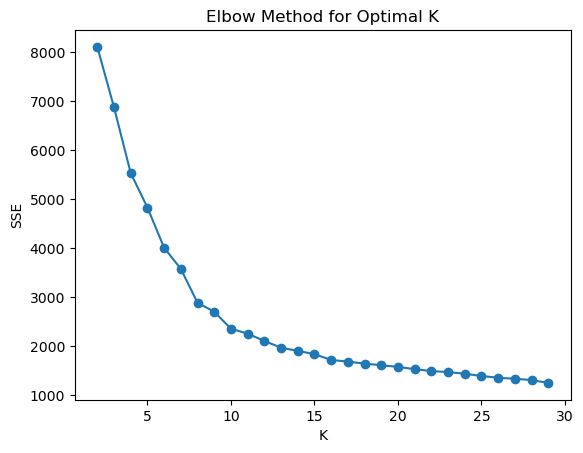

Elbow detected at K = 10


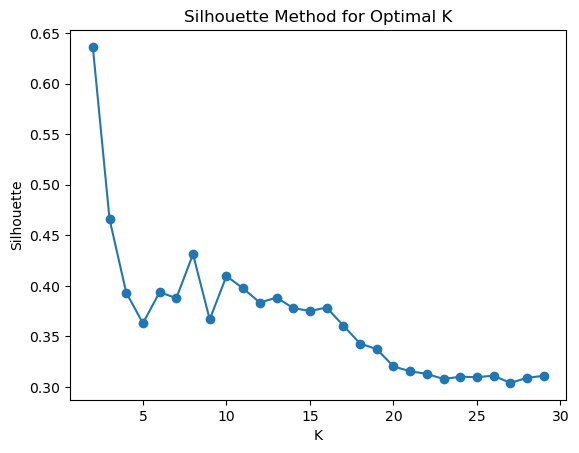

In [35]:
df_cluster_bisecting=df

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_bisecting)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

clusteringData_bisecting = output_dataset.select("features_scaled", "Severity")

clusteringData_bisecting.show(truncate=False)



#!pip install kneed
from kneed import KneeLocator
import matplotlib.pyplot as plt


sse_values = []
silhouette_values = []
for k in range(2,30):

    print('************************************************\n')

    bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=k)
    model = bisect_kmeans.fit(clusteringData_bisecting)
    
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    predictions = model.transform(clusteringData_bisecting)
    silhouette = evaluator.evaluate(predictions)
    sse = model.summary.trainingCost
    
    print(f"Results for K = {k}")
    print(f"Silhouette with squared euclidean distance: {silhouette:.4f}")
    print(f"SSE (Sum of Squared Errors): {sse}")
    sse_values.append(sse)
    silhouette_values.append(silhouette)

# Plot SSE per valutare l'elbow
plt.figure()
plt.plot(range(2, 30), sse_values, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 30), sse_values, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

plt.figure()
plt.plot(range(2, 30), silhouette_values, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.title("Silhouette Method for Optimal K")
plt.show()

In linea generale i risultati con questo algoritmo sono più scarsi per qualsiasi valore di K,
Facendo un tradeoff tra silhouette e SSE si puo dire che il k ideale per i nostri dati è compreso tra [4-9]

Bisecting K-Means(K=8) with respect to Severity

Silhouette  = 0.38574267317983524

SSE  = 21649.856945603125


Contingency Table:
severity       1      2     3    4
prediction                        
0            302   7806   475  163
1            109  14569   753  201
2             94  10563   208  294
3            296   6529   164  238
4           1795  23153  3053  282
5            244  31901  4249  331
6            149  35669  1754  607
7           2197  23667  1096  687


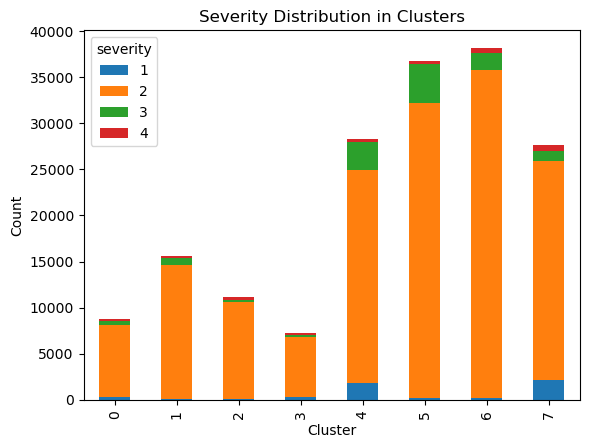

In [33]:
bisectingclusteringData_severity = output_dataset.select("features_scaled", "Severity")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8)
model = bisect_kmeans.fit(bisectingclusteringData_severity)
predictions = model.transform(bisectingclusteringData_severity)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'severity').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='severity', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Bisecting K-Means(K=8) with respect to State

Silhouette  = 0.38574267317983524

SSE  = 21649.856945603125


Contingency Table:
state            AZ       LA      MS     NM       TX
prediction                                          
0            7982.0      NaN     NaN  471.0    293.0
1           14631.0      NaN     NaN  283.0    718.0
2           10088.0      NaN     NaN  236.0    835.0
3            6704.0      NaN     NaN  270.0    253.0
4               NaN   7562.0   950.0   88.0  19683.0
5               NaN  11524.0  1010.0    2.0  24189.0
6               NaN   8546.0   890.0    8.0  28735.0
7              18.0   6138.0   633.0   55.0  20803.0


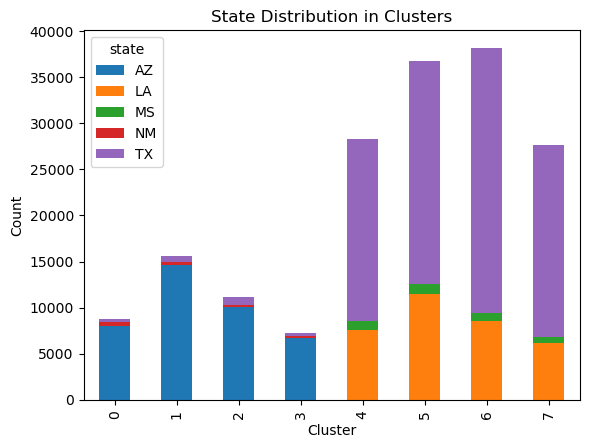

In [34]:
bisectingclusteringData_state= output_dataset.select("features_scaled", "State")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8)
model = bisect_kmeans.fit(bisectingclusteringData_state)
predictions = model.transform(bisectingclusteringData_state)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'state').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='state', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='State Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Bisecting K-Means(K=8) with respect to State

Silhouette  = 0.38574267317983524

SSE  = 21649.856945603125


Contingency Table:
Astronomical_Twilight    Day  Night
prediction                         
0                       7091   1655
1                      13729   1903
2                       8790   2369
3                       5497   1730
4                      23806   4477
5                      33284   3441
6                      31572   6607
7                      21249   6398


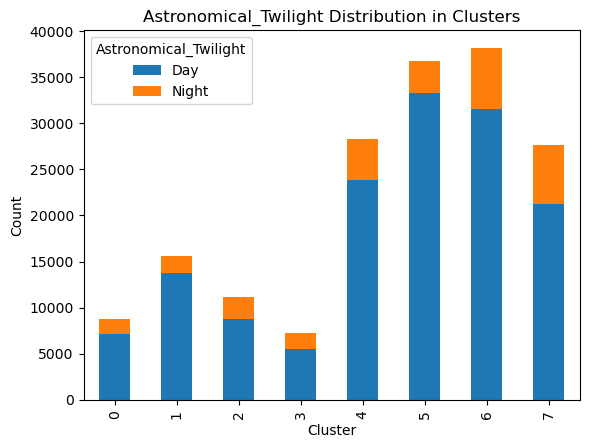

In [35]:
bisectingclusteringData_day= output_dataset.select("features_scaled", "Astronomical_Twilight")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8)
model = bisect_kmeans.fit(bisectingclusteringData_day)
predictions = model.transform(bisectingclusteringData_day)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Bisecting K-Means(K=8) with respect to Weather_Condition

Silhouette  = 0.38574267317983524

SSE  = 21649.856945603125


Contingency Table:
Weather_Condition   Cloudy  Foggy   Normal    Rain   Snow
prediction                                               
0                   1337.0   29.0   7104.0    78.0  198.0
1                   2388.0   50.0  13093.0   101.0    NaN
2                   3280.0   86.0   7374.0   408.0   11.0
3                   2110.0   82.0   4394.0   527.0  114.0
4                  14156.0  832.0   9504.0  3254.0  537.0
5                  14031.0  225.0  21713.0   738.0   18.0
6                  15372.0  181.0  20975.0  1646.0    5.0
7                  11641.0  872.0  11647.0  3458.0   29.0


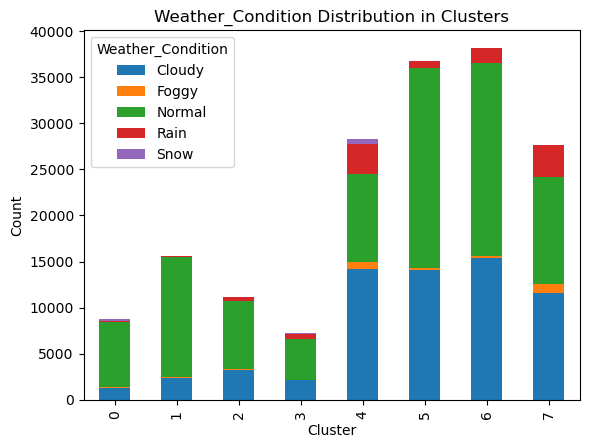

In [36]:
bisectingclusteringData_condition= output_dataset.select("features_scaled", "Weather_Condition")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8)
model = bisect_kmeans.fit(bisectingclusteringData_condition)
predictions = model.transform(bisectingclusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Silhouette  = 0.38574267317983524

SSE  = 21649.856945603125


Contingency Table:
day_of_the_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
prediction                                                             
0                  1322    1182       765     648      1504     1398   
1                  3098    2173      1755    1260      2406     2469   
2                  2030    1499      1277    1047      1755     1727   
3                   967    1094       783     596      1221     1219   
4                  3916    4937      2102    1453      5067     4942   
5                  7059    4714      4316    2916      6227     5695   
6                  7182    4595      5011    3472      6420     5368   
7                  4365    4769      2768    2255      4856     4413   

day_of_the_week  Wednesday  
prediction                  
0                     1927  
1                     2471  
2                     1824  
3                     1347  
4                     5866  
5                     5798  
6                     6131  

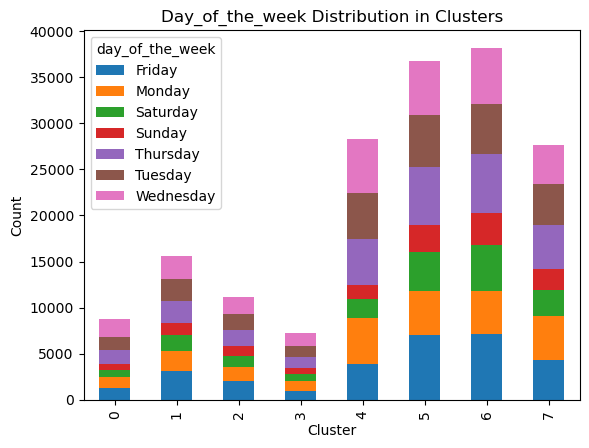

In [39]:
bisectingclusteringData_condition= output_dataset.select("features_scaled", "day_of_the_week")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8)
model = bisect_kmeans.fit(bisectingclusteringData_condition)
predictions = model.transform(bisectingclusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'day_of_the_week').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='day_of_the_week', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Day_of_the_week Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()



Silhouette  = 0.38574267317983524

SSE  = 21649.856945603125


Contingency Table:
season       Autumn   Spring   Summer   Winter
prediction                                    
0               NaN   4403.0    596.0   3747.0
1               NaN   9171.0   2846.0   3615.0
2            5400.0      NaN   3310.0   2449.0
3            2919.0      2.0   2474.0   1832.0
4               NaN  14312.0   3416.0  10555.0
5               NaN  20506.0   5156.0  11063.0
6           18016.0      NaN  11953.0   8210.0
7           11598.0      NaN   9851.0   6198.0


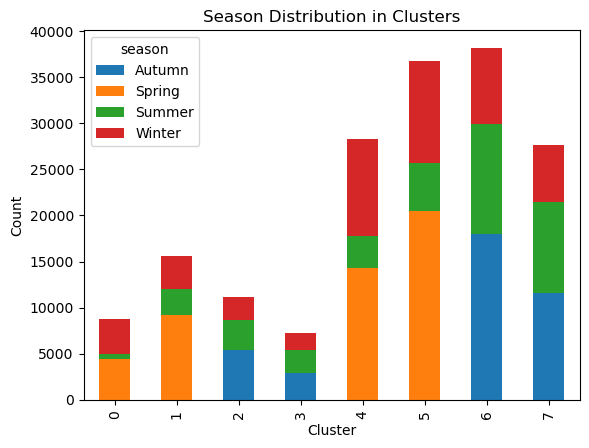

In [40]:
bisectingclusteringData_condition= output_dataset.select("features_scaled", "season")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8)
model = bisect_kmeans.fit(bisectingclusteringData_condition)
predictions = model.transform(bisectingclusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'season').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='season', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Season Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()



In [33]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
def workingDay_weekend(day_of):
    ins={'Monday','Tuesday','Wednesday','Thursday','Friday'}
    if day_of in ins:
        return 'WorkingDay'
    else:
        return 'Weekend'

udf_workingDay_weekend = udf(workingDay_weekend, StringType())
df = df.withColumn("Working_Weekend", udf_workingDay_weekend(col("day_of_the_week")))

Silhouette  = 0.38574267317983524

SSE  = 21649.856945603125


Contingency Table:
Working_Weekend  Weekend  WorkingDay
prediction                          
0                   1413        7333
1                   3015       12617
2                   2324        8835
3                   1379        5848
4                   3555       24728
5                   7232       29493
6                   8483       29696
7                   5023       22624


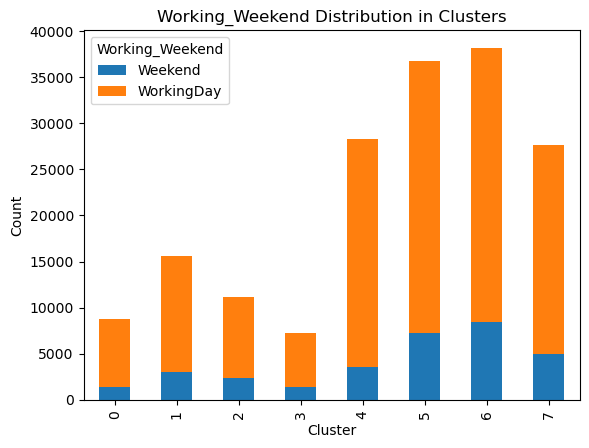

In [41]:
bisectingclusteringData_condition= output_dataset.select("features_scaled", "Working_Weekend")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=8)
model = bisect_kmeans.fit(bisectingclusteringData_condition)
predictions = model.transform(bisectingclusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Working_Weekend').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Working_Weekend', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Working_Weekend Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [2]:
#pip install .

Processing /home/jovyan/DDAM/Project_mio
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark-kmodes: filename=pyspark_kmodes-0.1.0-py2.py3-none-any.whl size=12754 sha256=4c5b7dc368dbba138f5c9714cf6efda477d2aa44022cf9d0a5b32e8b01f74708
  Stored in directory: /tmp/pip-ephem-wheel-cache-1fjlwd42/wheels/94/09/49/c3163c070eb36c78fc9ddc46b4e18530dc6a82a72b516dc206
Successfully built pyspark-kmodes
Note: you may need to restart the kernel to use updated packages.


In [5]:
from pyspark_kmodes import *

In [6]:
from pyspark.sql.functions import monotonically_increasing_id

In [7]:
df_with_row_id = df.withColumn("row_id", monotonically_increasing_id())

working_weekend(??????)

In [27]:
df_kmodes_id= df_with_row_id.select('row_id','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout',
                     'Station','Stop','Traffic_Calming','Traffic_Signal','hour','month','season','Weather_Condition','Astronomical_Twilight','Severity', 'Working_Weekend')

In [9]:
df_kmodes= df.select('City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout',
                     'Station','Stop','Traffic_Calming','Traffic_Signal','hour','month','season','Weather_Condition','Astronomical_Twilight',
                     'Severity')

SEVERITY

In [66]:
df_kmodes_severity=df_kmodes.drop('Severity')

In [67]:
df_kmodes_rdd=df_kmodes_severity.rdd

In [93]:
n_clusters = 10
max_iter = 10

method = EnsembleKModes(n_clusters, max_iter)

In [94]:
model = method.fit(df_kmodes_rdd)

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9, cost: 304.0
Run 1, iteration: 2/100, moves: 1, cost: 304.0
Avg cost/partition: 3.3777777777777778
Final centroids:
['Baton Rouge' 'East Baton Rouge' 'CALM' False False False False False
 False False False False False False False 15 8 'Summer' 'Normal' 'Day']
['Houston' 'Harris' 'N' False False False False False False False False
 False False False False 16 12 'Winter' 'Cloudy' 'Day']
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 17 4 'Spring' 'Cloudy' 'Day']
['Tucson' 'Pima' 'W' False False True False False False False False False
 False False False 15 2 'Winter' 'Normal' 'Day']
['Phoenix' 'Maricopa' 'CALM' False False True False False False False
 False False False False True 18 7 'Summer' 'Cloudy' 'Day']
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 16 9 'Autumn' 'No

In [95]:
lista_costi.append(method.mean_cost)

In [78]:
lista_costi=[]
for k in range(2,11):
    n_clusters = k
    max_iter = 10
    method = EnsembleKModes(n_clusters, max_iter)
    model = method.fit(df_kmodes_rdd)
    lista_costi.append(method.mean_cost)
    

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2, cost: 66.0
Run 1, iteration: 2/100, moves: 0, cost: 66.0
Avg cost/partition: 3.6666666666666665
Final centroids:
['Dallas' 'Dallas' 'CALM' False False False False False False False False
 False False False False 16 12 'Winter' 'Normal' 'Day']
['Houston' 'Harris' 'S' False False False False False False False False
 False False False False 15 4 'Spring' 'Cloudy' 'Day']


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1, cost: 104.0
Run 1, iteration: 2/100, moves: 0, cost: 104.0
Avg cost/partition: 3.8518518518518516
Final centroids:
['Dallas' 'Dallas' 'CALM' False False False False False False False False
 False False False False 16 2 'Summer' 'Normal' 'Day']
['Houston' 'Harris' 'SSE' False False False False False False False False
 False False False False 9 4 'Spring' 'Cloudy' 'Day']
['Sedona' 'Yavapai' 'SW' False False False False False False False False
 False False False False 13 12 'Winter' 'Cloudy' 'Night']


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Iteration  5


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9, cost: 127.0
Run 1, iteration: 2/100, moves: 2, cost: 124.0
Run 1, iteration: 3/100, moves: 1, cost: 124.0
Avg cost/partition: 3.4444444444444446
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 16 9 'Autumn' 'Normal' 'Day']
['Dallas' 'Dallas' 'SSE' False False False False False False False False
 False False False False 17 4 'Spring' 'Cloudy' 'Day']
['Baton Rouge' 'East Baton Rouge' 'CALM' False False False False False
 False False False False False False False 15 4 'Spring' 'Normal' 'Day']
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 8 2 'Winter' 'Normal' 'Day']


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Iteration  5


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 13, cost: 152.0
Run 1, iteration: 2/100, moves: 1, cost: 152.0
Avg cost/partition: 3.3777777777777778
Final centroids:
['Baton Rouge' 'East Baton Rouge' 'CALM' False False False False False
 False False False False False False False 15 4 'Summer' 'Normal' 'Day']
['Dallas' 'Dallas' 'N' False False False False False False False False
 False False False False 14 12 'Winter' 'Cloudy' 'Day']
['Houston' 'Harris' 'S' False False False False False False False False
 False False False False 16 8 'Summer' 'Cloudy' 'Day']
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 18 12 'Winter' 'Normal' 'Day']
['Fort Worth' 'Tarrant' 'CALM' False False False False False False False
 False False False False False 16 9 'Autumn' 'Normal' 'Day']


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9, cost: 193.0
Run 1, iteration: 2/100, moves: 2, cost: 192.0
Run 1, iteration: 3/100, moves: 1, cost: 192.0
Avg cost/partition: 3.5555555555555554
Final centroids:
['Baton Rouge' 'East Baton Rouge' 'CALM' False False False False False
 False False False False False False False 16 12 'Winter' 'Normal' 'Day']
['Dallas' 'Dallas' 'SSE' False False False False False False False False
 False False False False 12 4 'Spring' 'Cloudy' 'Day']
['Dallas' 'Collin' 'S' False False True False False False False False
 False False False True 8 4 'Spring' 'Normal' 'Day']
['Houston' 'Harris' 'CALM' False False False False False False False False
 False False False False 15 8 'Summer' 'Cloudy' 'Day']
['Tucson' 'Pima' 'S' False False False False False False False False False
 False False False 21 3 'Spring' 'Normal' 'Night']
['Phoenix' 'Maricopa' 'E' False False False False False False False Fal

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5, cost: 206.0
Run 1, iteration: 2/100, moves: 0, cost: 206.0
Avg cost/partition: 3.2698412698412698
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 16 12 'Winter' 'Normal' 'Day']
['Houston' 'Harris' 'S' False False False False False False False False
 False False False False 15 8 'Summer' 'Cloudy' 'Day']
['Tucson' 'Pima' 'W' False False True False False False False False False
 False False True 17 2 'Spring' 'Normal' 'Day']
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 8 4 'Spring' 'Normal' 'Day']
['Houston' 'Harris' 'CALM' False False False False False False False False
 False False False False 15 9 'Autumn' 'Normal' 'Day']
['New Orleans' 'Orleans' 'S' False False False False False False False
 False False False False False 14 2 'Winter' 'Cloudy' 'Day']
[

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8, cost: 242.0
Run 1, iteration: 2/100, moves: 1, cost: 242.0
Avg cost/partition: 3.361111111111111
Final centroids:
['Baton Rouge' 'East Baton Rouge' 'CALM' False False False False False
 False False False False False False False 15 12 'Winter' 'Normal' 'Day']
['Houston' 'Harris' 'SSE' False False False False False False False False
 False False False False 15 7 'Summer' 'Cloudy' 'Day']
['Dallas' 'Dallas' 'SSE' False False False False False False False False
 False False False False 7 4 'Spring' 'Cloudy' 'Day']
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 22 9 'Autumn' 'Normal' 'Night']
['Phoenix' 'Maricopa' 'S' False False False False False False False False
 False False False False 16 8 'Summer' 'Normal' 'Day']
['Austin' 'Travis' 'CALM' False False False False False False False False
 False False False False 16 11 'A

Iteration  0


TypeError: slice indices must be integers or None or have an __index__ method

In [81]:
#!pip install kneed

  Using cached kneed-0.8.5-py3-none-any.whl (10 kB)


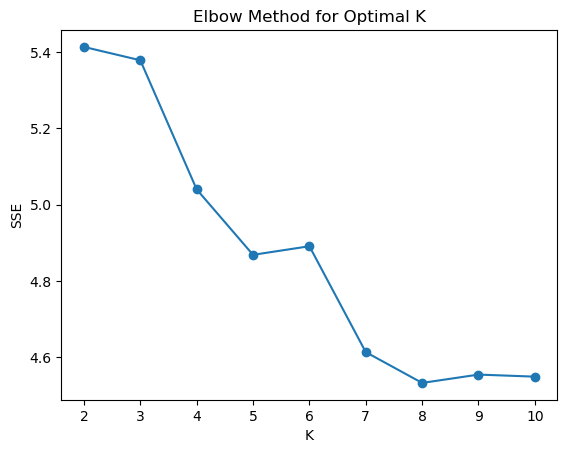

Elbow detected at K = 5


In [97]:
from kneed import KneeLocator
plt.figure()
plt.plot(range(2, 11), lista_costi, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 11), lista_costi, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")


PROVO K=5

In [103]:
n_clusters = 5
max_iter = 10

method = EnsembleKModes(n_clusters, max_iter)

In [104]:
model = method.fit(df_kmodes_rdd)

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2, cost: 161.0
Run 1, iteration: 2/100, moves: 0, cost: 161.0
Avg cost/partition: 3.577777777777778
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 16 4 'Spring' 'Normal' 'Day']
['Austin' 'Travis' 'CALM' False False False False False False False False
 False False False False 23 12 'Winter' 'Cloudy' 'Night']
['Dallas' 'Dallas' 'S' False False True False False False False False
 False False False True 16 6 'Summer' 'Cloudy' 'Day']
['Baton Rouge' 'East Baton Rouge' 'S' False False False False False False
 False False False False False False 7 7 'Summer' 'Cloudy' 'Day']
['Houston' 'Harris' 'CALM' False False False False False False False False
 False False False False 17 2 'Winter' 'Normal' 'Day']


In [105]:
predictions=model.predict(df_kmodes_rdd)
#predictions.collect()

In [106]:
predictions.collect()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [107]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [108]:
schema = StructType([
    StructField("predictions", IntegerType(), True)
])

In [109]:
df_predictions = spark.createDataFrame(predictions.map(lambda x: (int(x),)), schema)

In [110]:
df_predictions.show()

+-----------+
|predictions|
+-----------+
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
+-----------+
only showing top 20 rows



In [111]:
df_predictions_id = df_predictions.withColumn("row_id", monotonically_increasing_id())

In [114]:
joint=df_kmodes_id.join(df_predictions_id, 'row_id')

Contingency Table:
Severity        1      2     3     4
predictions                         
0            1537  63034  4542  1322
1             315  21683   591   468
2            1300  12215  1047   109
3            1837  26298  2777   543
4             197  30627  2795   361


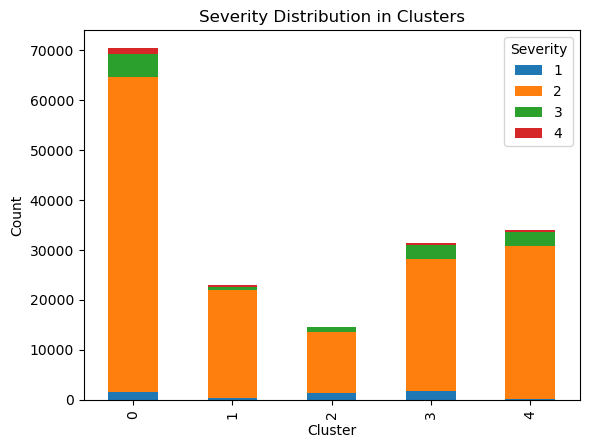

In [115]:
contingency_table = joint.groupBy('predictions', 'Severity').count().toPandas()
pivot_table = contingency_table.pivot(index='predictions', columns='Severity', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


PROVO K=8

In [117]:
n_clusters = 8
max_iter = 10

method = EnsembleKModes(n_clusters, max_iter)

In [118]:
model = method.fit(df_kmodes_rdd)

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14, cost: 243.0
Run 1, iteration: 2/100, moves: 2, cost: 242.0
Run 1, iteration: 3/100, moves: 0, cost: 242.0
Avg cost/partition: 3.361111111111111
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 8 2 'Winter' 'Normal' 'Day']
['Houston' 'Harris' 'S' False False False False False False False False
 False False False False 15 12 'Winter' 'Cloudy' 'Night']
['San Antonio' 'Bexar' 'S' False False False False False False False False
 False False False False 7 4 'Spring' 'Cloudy' 'Day']
['Dallas' 'Dallas' 'SSE' False False False False False False False False
 False False False False 8 11 'Autumn' 'Normal' 'Day']
['Maricopa' 'Pinal' 'S' False False False False False False False False
 False False False False 7 7 'Summer' 'Normal' 'Day']
['Baton Rouge' 'East Baton Rouge' 'W' False False False False False False
 Fals

In [119]:
predictions=model.predict(df_kmodes_rdd)
#predictions.collect()

In [107]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [121]:
schema = StructType([
    StructField("predictions", IntegerType(), True)
])

In [122]:
df_predictions = spark.createDataFrame(predictions.map(lambda x: (int(x),)), schema)

In [124]:
df_predictions_id = df_predictions.withColumn("row_id", monotonically_increasing_id())

In [129]:
joint=df_kmodes_id.join(df_predictions_id, 'row_id')

Contingency Table:
Severity        1      2     3    4
predictions                        
0             649  32899  2723  527
1             350  22343  1589  312
2            1019  19598  2505  359
3             720  24845  1758  519
4            1297  11695  1554  421
5             495  16745  1069  158
6             393  15028   231  336
7             263  10704   323  171


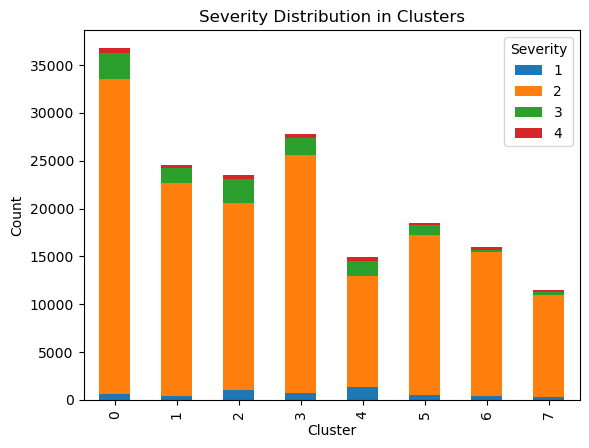

In [130]:
contingency_table = joint.groupBy('predictions', 'Severity').count().toPandas()
pivot_table = contingency_table.pivot(index='predictions', columns='Severity', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


SEASON

In [136]:
df_kmodes_season=df_kmodes.drop('season')

In [139]:
df_kmodes_rdd=df_kmodes_season.rdd

In [140]:
df_kmodes_rdd.collect()

[Row(City='Peridot', County='Graham', Wind_Direction='ESE', Amenity=False, Bump=False, Crossing=False, Give_Way=False, Junction=False, No_Exit=False, Railway=False, Roundabout=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, hour=3, month=4, Weather_Condition='Normal', Astronomical_Twilight='Night', Severity=2),
 Row(City='Safford', County='Graham', Wind_Direction='SE', Amenity=False, Bump=False, Crossing=False, Give_Way=False, Junction=False, No_Exit=False, Railway=False, Roundabout=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, hour=22, month=4, Weather_Condition='Normal', Astronomical_Twilight='Night', Severity=2),
 Row(City='Safford', County='Graham', Wind_Direction='NW', Amenity=False, Bump=False, Crossing=False, Give_Way=False, Junction=False, No_Exit=False, Railway=False, Roundabout=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, hour=23, month=4, Weather_Condition='Normal', Astronomical

In [161]:
n_clusters = 10
max_iter = 10

method = EnsembleKModes(n_clusters, max_iter)

In [162]:
model = method.fit(df_kmodes_rdd)

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 25, cost: 271.0
Run 1, iteration: 2/100, moves: 4, cost: 271.0
Avg cost/partition: 3.011111111111111
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 15 12 'Normal' 'Day' 2]
['Houston' 'Harris' 'CALM' False False False False False False False False
 False False False False 4 12 'Normal' 'Night' 2]
['Tyler' 'Smith' 'S' False False False False False False False False False
 False False False 7 5 'Cloudy' 'Day' 2]
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 8 5 'Normal' 'Day' 2]
['Lake Havasu City' 'Mohave' 'N' False False False False False False False
 False False False False False 14 2 'Cloudy' 'Day' 2]
['Sedona' 'Yavapai' 'SW' False False False False False False False False
 False False False False 13 7 'Rain' 'Day' 2]
['Tucson' 'Pima' 'W' False False True

In [163]:
lista_costi.append(method.mean_cost)

In [141]:
lista_costi=[]
for k in range(2,11):
    n_clusters = k
    max_iter = 10
    method = EnsembleKModes(n_clusters, max_iter)
    model = method.fit(df_kmodes_rdd)
    lista_costi.append(method.mean_cost)
    

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 59.0
Avg cost/partition: 3.2777777777777777
Final centroids:
['Houston' 'Harris' 'S' False False False False False False False False
 False False False False 16 2 'Normal' 'Day' 2]
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 15 4 'Normal' 'Day' 2]


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 84.0
Avg cost/partition: 3.111111111111111
Final centroids:
['Houston' 'Harris' 'CALM' False False False False False False False False
 False False False False 16 12 'Normal' 'Day' 2]
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 17 8 'Cloudy' 'Day' 2]
['Sedona' 'Yavapai' 'CALM' False False False False False False False False
 False False False False 1 12 'Cloudy' 'Night' 2]


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2, cost: 121.0
Run 1, iteration: 2/100, moves: 0, cost: 121.0
Avg cost/partition: 3.361111111111111
Final centroids:
['Baton Rouge' 'East Baton Rouge' 'CALM' False False False False False
 False False False False False False False 16 4 'Normal' 'Day' 2]
['Houston' 'Harris' 'S' False False False False False False False False
 False False False False 20 12 'Cloudy' 'Night' 2]
['Phoenix' 'Maricopa' 'N' False False False False False False False False
 False False False False 18 2 'Cloudy' 'Day' 2]
['Dallas' 'Dallas' 'SSE' False False False False False False False False
 False False False False 16 8 'Cloudy' 'Day' 2]


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6, cost: 154.0
Run 1, iteration: 2/100, moves: 0, cost: 154.0
Avg cost/partition: 3.422222222222222
Final centroids:
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 16 8 'Normal' 'Day' 2]
['Austin' 'Travis' 'CALM' False False False False False False False False
 False False False False 23 12 'Cloudy' 'Night' 2]
['Houston' 'Harris' 'S' False False False False False False False False
 False False False False 15 8 'Cloudy' 'Day' 2]
['Baton Rouge' 'East Baton Rouge' 'CALM' False False False False False
 False False False False False False False 14 4 'Cloudy' 'Day' 2]
['Tucson' 'Pima' 'CALM' False False True False False False False False
 False False False True 17 2 'Normal' 'Day' 2]


Iteration  0


TypeError: slice indices must be integers or None or have an __index__ method

In [81]:
#!pip install kneed

  Using cached kneed-0.8.5-py3-none-any.whl (10 kB)


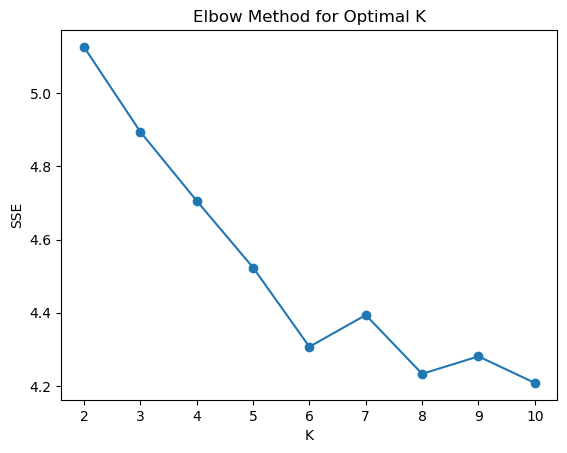

Elbow detected at K = 6


In [165]:
from kneed import KneeLocator
plt.figure()
plt.plot(range(2, 11), lista_costi, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 11), lista_costi, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")


PROVO K=6

In [166]:
n_clusters = 6
max_iter = 10

method = EnsembleKModes(n_clusters, max_iter)

In [167]:
model = method.fit(df_kmodes_rdd)

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8, cost: 178.0
Run 1, iteration: 2/100, moves: 1, cost: 178.0
Avg cost/partition: 3.2962962962962963
Final centroids:
['Dallas' 'Dallas' 'CALM' False False False False False False False False
 False False False False 17 8 'Normal' 'Day' 2]
['Houston' 'Harris' 'SSE' False False False False False False False False
 False False False False 16 2 'Cloudy' 'Day' 2]
['Shreveport' 'Caddo' 'S' False False False False False False False False
 False False False False 16 4 'Cloudy' 'Day' 2]
['Maricopa' 'Pinal' 'W' False False False False False False False False
 False False False False 1 12 'Normal' 'Night' 2]
['Baton Rouge' 'East Baton Rouge' 'CALM' False False False False False
 False False False False False False False 15 5 'Normal' 'Day' 2]
['Jal' 'Lea' 'WSW' False False False False False False False False False
 False False False 8 12 'Normal' 'Day' 2]


In [169]:
predictions=model.predict(df_kmodes_rdd)
#predictions.collect()

In [107]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [171]:
schema = StructType([
    StructField("predictions", IntegerType(), True)
])

In [172]:
df_predictions = spark.createDataFrame(predictions.map(lambda x: (int(x),)), schema)

In [173]:
df_predictions_id = df_predictions.withColumn("row_id", monotonically_increasing_id())

In [174]:
joint=df_kmodes_id.join(df_predictions_id, 'row_id')

Contingency Table:
season       Autumn  Spring  Summer  Winter
predictions                                
0             18981   16745   23486   16344
1              9830   12018    8945   16177
2              1387    6886    1808    1939
3              2823    2280    1365    5030
4              4046    9312    3286    4202
5               866    1153     712    3977


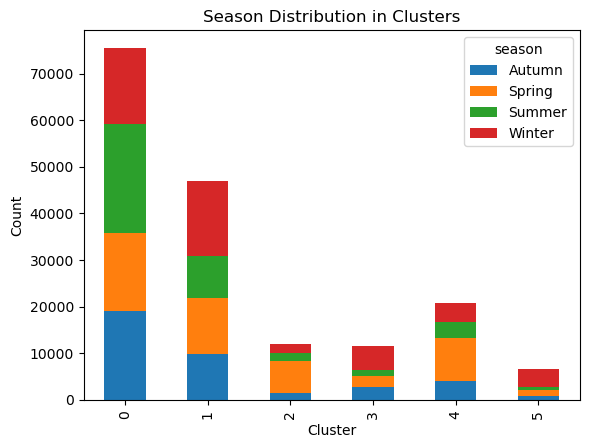

In [175]:
contingency_table = joint.groupBy('predictions', 'season').count().toPandas()
pivot_table = contingency_table.pivot(index='predictions', columns='season', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Season Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


WORKING_WEEKEND

In [12]:
df_kmodes_rdd=df_kmodes.rdd

In [140]:
df_kmodes_rdd.collect()

[Row(City='Peridot', County='Graham', Wind_Direction='ESE', Amenity=False, Bump=False, Crossing=False, Give_Way=False, Junction=False, No_Exit=False, Railway=False, Roundabout=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, hour=3, month=4, Weather_Condition='Normal', Astronomical_Twilight='Night', Severity=2),
 Row(City='Safford', County='Graham', Wind_Direction='SE', Amenity=False, Bump=False, Crossing=False, Give_Way=False, Junction=False, No_Exit=False, Railway=False, Roundabout=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, hour=22, month=4, Weather_Condition='Normal', Astronomical_Twilight='Night', Severity=2),
 Row(City='Safford', County='Graham', Wind_Direction='NW', Amenity=False, Bump=False, Crossing=False, Give_Way=False, Junction=False, No_Exit=False, Railway=False, Roundabout=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, hour=23, month=4, Weather_Condition='Normal', Astronomical

In [161]:
n_clusters = 10
max_iter = 10

method = EnsembleKModes(n_clusters, max_iter)

In [162]:
model = method.fit(df_kmodes_rdd)

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 25, cost: 271.0
Run 1, iteration: 2/100, moves: 4, cost: 271.0
Avg cost/partition: 3.011111111111111
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 15 12 'Normal' 'Day' 2]
['Houston' 'Harris' 'CALM' False False False False False False False False
 False False False False 4 12 'Normal' 'Night' 2]
['Tyler' 'Smith' 'S' False False False False False False False False False
 False False False 7 5 'Cloudy' 'Day' 2]
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 8 5 'Normal' 'Day' 2]
['Lake Havasu City' 'Mohave' 'N' False False False False False False False
 False False False False False 14 2 'Cloudy' 'Day' 2]
['Sedona' 'Yavapai' 'SW' False False False False False False False False
 False False False False 13 7 'Rain' 'Day' 2]
['Tucson' 'Pima' 'W' False False True

In [163]:
lista_costi.append(method.mean_cost)

In [13]:
lista_costi=[]
for k in range(2,11):
    n_clusters = k
    max_iter = 10
    method = EnsembleKModes(n_clusters, max_iter)
    model = method.fit(df_kmodes_rdd)
    lista_costi.append(method.mean_cost)
    

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 63.0
Avg cost/partition: 3.5
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 16 8 'Summer' 'Normal' 'Day' 2]
['Houston' 'Harris' 'S' False False False False False False False False
 False False False False 15 4 'Spring' 'Cloudy' 'Day' 2]


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1, cost: 105.0
Run 1, iteration: 2/100, moves: 0, cost: 105.0
Avg cost/partition: 3.888888888888889
Final centroids:
['Baton Rouge' 'East Baton Rouge' 'CALM' False False False False False
 False False False False False False False 16 4 'Spring' 'Normal' 'Day' 2]
['Houston' 'Harris' 'CALM' False False False False False False False False
 False False False False 1 12 'Winter' 'Cloudy' 'Night' 2]
['Mayer' 'Yavapai' 'CALM' False False False False False False False False
 False False False False 8 7 'Summer' 'Cloudy' 'Day' 2]


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Iteration  5


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4, cost: 132.0
Run 1, iteration: 2/100, moves: 0, cost: 132.0
Avg cost/partition: 3.6666666666666665
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 16 12 'Winter' 'Normal' 'Day' 2]
['Houston' 'Harris' 'S' False False False False False False False False
 False False False False 15 4 'Spring' 'Cloudy' 'Day' 2]
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 17 7 'Summer' 'Cloudy' 'Day' 2]
['San Antonio' 'Bexar' 'S' False False False False False False False False
 False False False False 8 3 'Spring' 'Normal' 'Day' 3]


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6, cost: 152.0
Run 1, iteration: 2/100, moves: 0, cost: 152.0
Avg cost/partition: 3.3777777777777778
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 15 12 'Winter' 'Normal' 'Day' 2]
['Dallas' 'Dallas' 'SSE' False False False False False False False False
 False False False False 17 8 'Summer' 'Cloudy' 'Day' 2]
['Houston' 'Harris' 'N' False False False False False False False False
 False False False False 16 9 'Autumn' 'Cloudy' 'Day' 2]
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 8 8 'Summer' 'Normal' 'Day' 2]
['Baton Rouge' 'East Baton Rouge' 'W' False False False False False False
 False False False False False False 16 4 'Spring' 'Normal' 'Day' 2]


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6, cost: 201.0
Run 1, iteration: 2/100, moves: 0, cost: 201.0
Avg cost/partition: 3.7222222222222223
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 15 4 'Spring' 'Normal' 'Day' 2]
['Houston' 'Harris' 'N' False False False False False False False False
 False False False False 16 12 'Winter' 'Cloudy' 'Night' 2]
['Phoenix' 'Maricopa' 'VAR' False False False False False False False
 False False False False False 17 8 'Summer' 'Cloudy' 'Day' 2]
['Baton Rouge' 'East Baton Rouge' 'NNE' False False True False False False
 False False False False False True 8 9 'Autumn' 'Normal' 'Day' 2]
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 15 2 'Winter' 'Normal' 'Day' 2]
['San Antonio' 'Bexar' 'SSE' False False False False False False False
 False False False False False

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Iteration  5


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5, cost: 216.0
Run 1, iteration: 2/100, moves: 1, cost: 216.0
Avg cost/partition: 3.4285714285714284
Final centroids:
['Baton Rouge' 'East Baton Rouge' 'CALM' False False False False False
 False False False False False False False 16 12 'Winter' 'Normal' 'Day' 2]
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 15 8 'Summer' 'Cloudy' 'Day' 2]
['Sedona' 'Yavapai' 'S' False False False False False False False False
 False False False False 3 12 'Winter' 'Normal' 'Night' 2]
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 19 12 'Winter' 'Cloudy' 'Night' 2]
['Fort Worth' 'Tarrant' 'CALM' False False False False False False False
 False False False False False 6 11 'Autumn' 'Normal' 'Day' 2]
['Dallas' 'Dallas' 'SSE' False False False False False False False False
 False False False

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 16, cost: 228.0
Run 1, iteration: 2/100, moves: 3, cost: 228.0
Avg cost/partition: 3.1666666666666665
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 16 4 'Summer' 'Normal' 'Day' 2]
['Houston' 'Harris' 'S' False False False False False False False False
 False False False False 7 8 'Summer' 'Cloudy' 'Day' 2]
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 8 12 'Winter' 'Normal' 'Day' 2]
['Austin' 'Travis' 'N' False False False False False False False False
 False False False False 14 12 'Winter' 'Cloudy' 'Day' 2]
['San Antonio' 'Bexar' 'SSE' False False False False False False False
 False False False False False 8 5 'Spring' 'Cloudy' 'Day' 3]
['Dallas' 'Dallas' 'SSE' False False False False False False False False
 False False False False 15 4 'Spring' 'Clou

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 16, cost: 266.0
Run 1, iteration: 2/100, moves: 3, cost: 266.0
Avg cost/partition: 3.2839506172839505
Final centroids:
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 17 8 'Summer' 'Normal' 'Day' 2]
['Austin' 'Travis' 'N' False False False False False False False False
 False False False False 19 12 'Winter' 'Cloudy' 'Night' 2]
['Houston' 'Harris' 'SSE' False False False False False False False False
 False False False False 16 11 'Autumn' 'Cloudy' 'Day' 2]
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 7 9 'Autumn' 'Normal' 'Day' 2]
['Phoenix' 'Maricopa' 'W' False False True False False False False False
 False False False True 7 3 'Spring' 'Normal' 'Day' 2]
['Baton Rouge' 'East Baton Rouge' 'CALM' False False False False False
 False False False False False False False 8 2

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 19, cost: 307.0
Run 1, iteration: 2/100, moves: 3, cost: 307.0
Avg cost/partition: 3.411111111111111
Final centroids:
['Dallas' 'Dallas' 'CALM' False False False False False False False False
 False False False False 16 9 'Autumn' 'Normal' 'Day' 2]
['Houston' 'Harris' 'SSE' False False True False False False False False
 False False False True 7 4 'Spring' 'Cloudy' 'Day' 2]
['Austin' 'Travis' 'CALM' False False False False False False False False
 False False False False 19 12 'Winter' 'Cloudy' 'Night' 2]
['New Orleans' 'Orleans' 'S' False False False False False False False
 False False False False False 13 7 'Summer' 'Cloudy' 'Day' 2]
['Kingman' 'Mohave' 'SSW' False False False False False False False False
 False False False False 15 4 'Spring' 'Normal' 'Day' 2]
['Fort Hancock' 'Hudspeth' 'ENE' False False False False True False False
 False False False False False 16 12 '

In [15]:
#!pip install kneed

  Using cached kneed-0.8.5-py3-none-any.whl (10 kB)


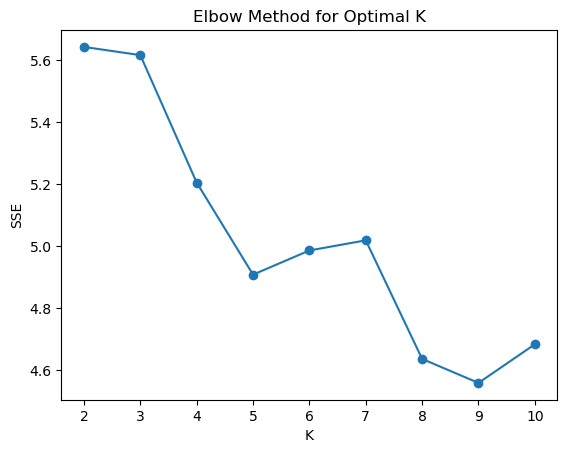

Elbow detected at K = 5


In [16]:
from kneed import KneeLocator
plt.figure()
plt.plot(range(2, 11), lista_costi, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 11), lista_costi, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")


PROVO K=5

In [17]:
n_clusters = 5
max_iter = 10

method = EnsembleKModes(n_clusters, max_iter)

In [18]:
model = method.fit(df_kmodes_rdd)

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3, cost: 170.0
Run 1, iteration: 2/100, moves: 0, cost: 170.0
Avg cost/partition: 3.7777777777777777
Final centroids:
['Phoenix' 'Maricopa' 'CALM' False False False False False False False
 False False False False False 15 7 'Summer' 'Normal' 'Day' 2]
['Dallas' 'Dallas' 'S' False False False False False False False False
 False False False False 19 12 'Winter' 'Cloudy' 'Night' 2]
['San Antonio' 'Bexar' 'SSE' False False False False False False False
 False False False False False 8 11 'Autumn' 'Cloudy' 'Day' 2]
['New Orleans' 'Orleans' 'CALM' False False False False False False False
 False False False False False 7 2 'Winter' 'Cloudy' 'Day' 2]
['Houston' 'Harris' 'S' False False False False False False False False
 False False False False 16 12 'Winter' 'Normal' 'Day' 2]


In [19]:
predictions=model.predict(df_kmodes_rdd)
#predictions.collect()

In [20]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [21]:
schema = StructType([
    StructField("predictions", IntegerType(), True)
])

In [22]:
df_predictions = spark.createDataFrame(predictions.map(lambda x: (int(x),)), schema)

In [23]:
df_predictions_id = df_predictions.withColumn("row_id", monotonically_increasing_id())

In [29]:
joint=df_kmodes_id.join(df_predictions_id, 'row_id')

Contingency Table:
Working_Weekend  Weekend  WorkingDay
predictions                         
0                  12590       58458
1                   7201       21208
2                   3683       20183
3                   3534       16551
4                   5416       24774


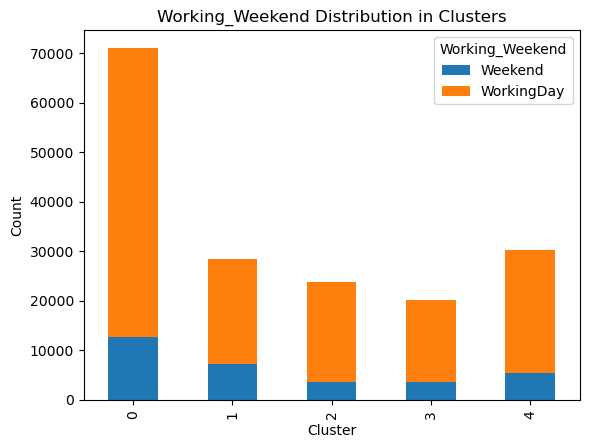

In [30]:
contingency_table = joint.groupBy('predictions', 'Working_Weekend').count().toPandas()
pivot_table = contingency_table.pivot(index='predictions', columns='Working_Weekend', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Working_Weekend Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()
